In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [10]:
# 1. Cargar datos y calcular retornos diarios
df = pd.read_csv('DATA.csv', parse_dates=['Date'])
df_prices = df.set_index('Date')

df_returns = df.set_index('Date').pct_change().dropna()

# 2. Calcular métricas por activo: media y desviación estándar
metrics_df = pd.DataFrame({
    'Asset': df_returns.columns,
    'Mean': df_returns.mean().values,
    'Std': df_returns.std().values
})

In [11]:
# 3. Escalar métricas con StandardScaler
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(metrics_df[['Mean', 'Std']])

# 4. Clustering K-Means en métricas escaladas
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=42)
metrics_df['Cluster'] = kmeans.fit_predict(scaled_metrics)

# 5. Mapear clústeres a categorías de riesgo por orden de volatilidad media
cluster_order = metrics_df.groupby('Cluster')['Std'].mean().sort_values().index.tolist()
risk_labels = ['Conservador', 'Moderado', 'Arriesgado', 'Muy Arriesgado']
cluster_to_label = {cluster_order[i]: risk_labels[i] for i in range(4)}
metrics_df['Risk_Category'] = metrics_df['Cluster'].map(cluster_to_label)

metrics_df


,Asset,Mean,Std,Cluster,Risk_Category
0,PG,0.000106,0.010560,0,Conservador
1,KO,0.000274,0.009404,0,Conservador
2,JNJ,-0.000040,0.010875,0,Conservador
3,WMT,0.001406,0.013041,0,Conservador
4,MSFT,0.000788,0.014813,0,Conservador
5,AAPL,0.000412,0.016983,0,Conservador
6,MCD,0.000193,0.011085,0,Conservador
7,HD,0.000534,0.013467,0,Conservador
8,DOCU,0.001372,0.027494,2,Arriesgado
9,META,0.002102,0.022761,1,Moderado


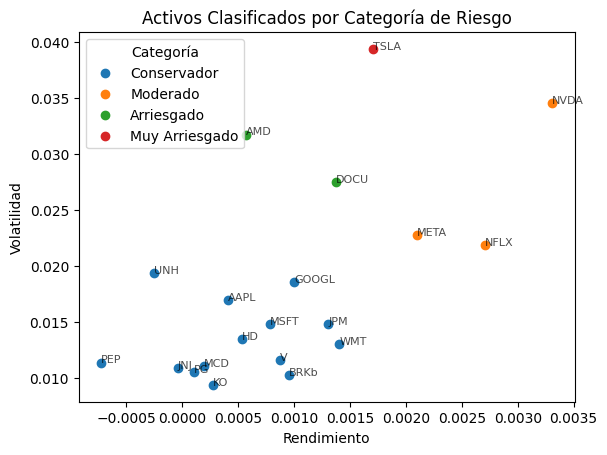

In [12]:
# 6. Gráfico scatter único con colores por categoría
fig, ax = plt.subplots()
for label in risk_labels:
    subset = metrics_df[metrics_df['Risk_Category'] == label]
    ax.scatter(subset['Mean'], subset['Std'], label=label)
    for _, row in subset.iterrows():
        ax.text(row['Mean'], row['Std'], row['Asset'], fontsize=8, alpha=0.7)

ax.set_xlabel('Rendimiento')
ax.set_ylabel('Volatilidad')
ax.set_title('Activos Clasificados por Categoría de Riesgo')
ax.legend(title='Categoría')
plt.show()

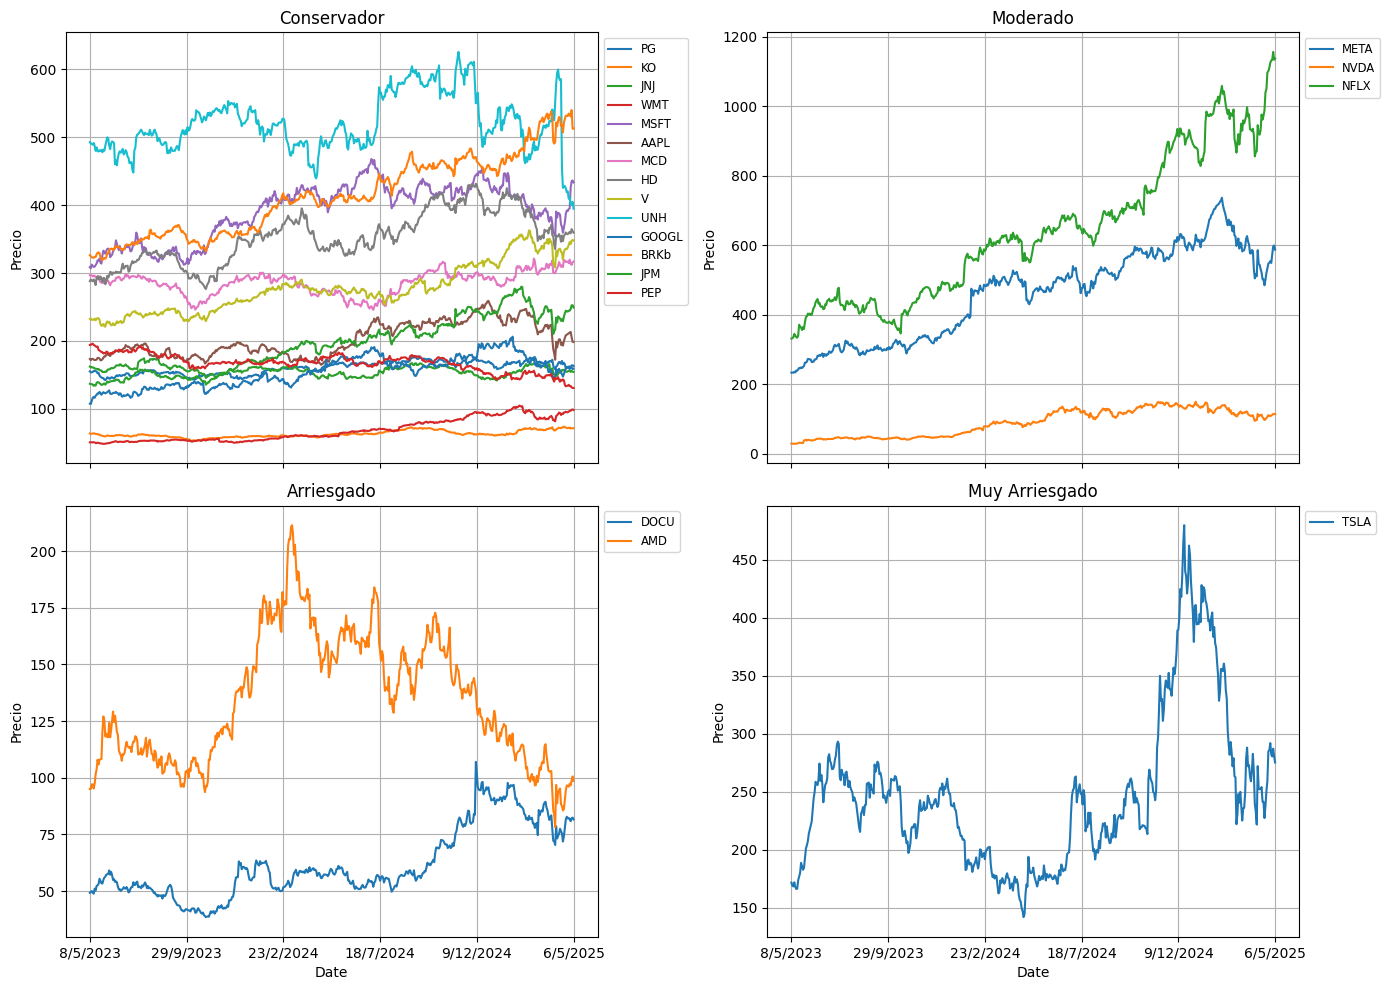

In [14]:
# 5. Crear subplots para cada categoría
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, label in zip(axes, risk_labels):
    assets = metrics_df[metrics_df['Risk_Category'] == label]['Asset'].tolist()
    df_prices[assets].plot(ax=ax, legend=False)
    ax.set_title(f'{label}')
    ax.set_ylabel('Precio')
    ax.grid(True)
    ax.legend(assets, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    
plt.tight_layout()
plt.show()

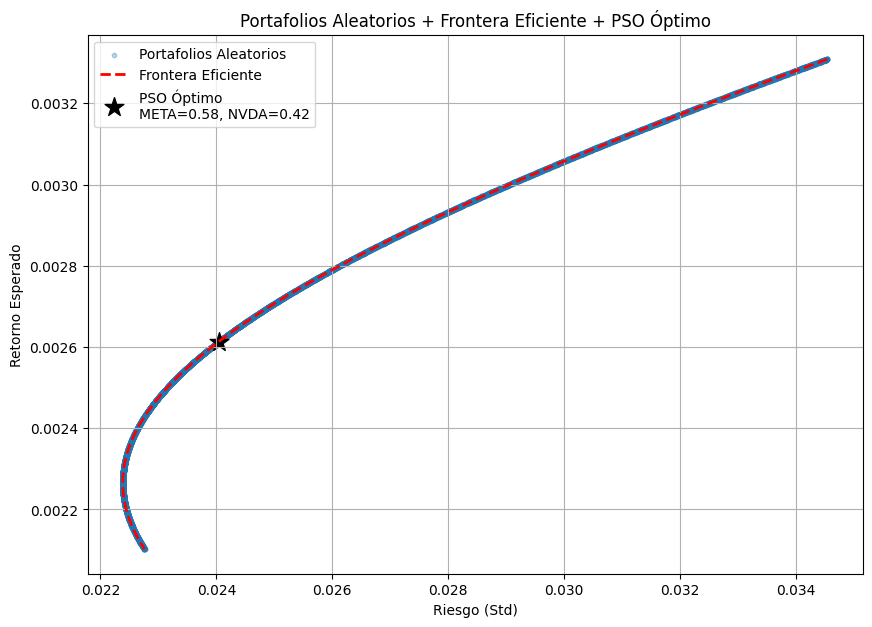

Pesos Óptimos PSO: META = 57.61%, NVDA = 42.39%
Retorno Esperado: 0.0026 (0.26%)
Volatilidad: 0.0240 (2.40%)
Ratio Sharpe: 0.1087


In [42]:
# 6. Seleccionar 2 activos, META y NVDA
assets = ['META', 'NVDA']
rt = df_returns[assets].values

# 7. Monte Carlo de portafolios aleatorios
n_portfolios = 10000
weights_mc = np.random.dirichlet(alpha=[1,1], size=n_portfolios)
port_means = weights_mc.dot(rt.mean(axis=0))
cov_mat = np.cov(rt, rowvar=False)
port_vars = np.einsum('ij,jk,ik->i', weights_mc, cov_mat, weights_mc)
port_stds = np.sqrt(port_vars)

# 8. Frontera eficiente (grid para plot)
grid_w = np.linspace(0,1,100)
mean_vec = rt.mean(axis=0)
grid_means = grid_w * mean_vec[0] + (1-grid_w) * mean_vec[1]
grid_vars = (grid_w**2 * cov_mat[0,0] +
             (1-grid_w)**2 * cov_mat[1,1] +
             2*grid_w*(1-grid_w)*cov_mat[0,1])
grid_stds = np.sqrt(grid_vars)

# 5. PSO para optimizar Sharpe
np.random.seed(42)
n_particles = 200
iterations = 100
c1, c2 = 1.5, 1.5

# Inicializar partículas
x = np.random.rand(n_particles, 2)
vx = np.zeros_like(x)
# historial de mejores locales y global
x_best_local = x.copy()
fx_best_local = np.full(n_particles, np.inf)
x_best_global = None
fx_best_global = np.inf

for t in range(iterations):
    # validación de pesos
    x = np.clip(x, 1e-8, 1)
    x = x / x.sum(axis=1, keepdims=True)
    # calcular Sharpe negativo
    mean_ports = (rt.mean(axis=0) * x).sum(axis=1)  # wrong shape

    # Actually calculate for each particle:
    mean_ports = x.dot(mean_vec)
    std_ports = np.sqrt(np.einsum('ij,jk,ik->i', x, cov_mat, x))
    sharpe = mean_ports / std_ports
    fx = -sharpe
    
    # actualizar global
    idx_min = np.argmin(fx)
    if fx[idx_min] < fx_best_global:
        fx_best_global = fx[idx_min]
        x_best_global = x[idx_min].copy()
    # actualizar locales
    mask = fx < fx_best_local
    x_best_local[mask] = x[mask]
    fx_best_local[mask] = fx[mask]
    # actualizar velocidades y posiciones
    inertia = 0.01 * (1 - t/iterations)
    r1 = np.random.rand(n_particles,2)
    r2 = np.random.rand(n_particles,2)
    vx = inertia*vx + c1*r1*(x_best_local - x) + c2*r2*(x_best_global - x)
    x += vx

# obtener resultado PSO
w_pso = np.clip(x_best_global,1e-8,1)
w_pso /= w_pso.sum()
ret_pso = w_pso.dot(mean_vec)
vol_pso = np.sqrt(w_pso.dot(cov_mat).dot(w_pso))
sharpe_pso = ret_pso/vol_pso

# 6. Plot
plt.figure(figsize=(10,7))
plt.scatter(port_stds, port_means, s=10, alpha=0.3, label='Portafolios Aleatorios')
plt.plot(grid_stds, grid_means, 'r--', linewidth=2, label='Frontera Eficiente')
plt.scatter(vol_pso, ret_pso, c='black', marker='*', s=200,
            label=f'PSO Óptimo\nMETA={w_pso[0]:.2f}, NVDA={w_pso[1]:.2f}')
plt.xlabel('Riesgo (Std)')
plt.ylabel('Retorno Esperado')
plt.title('Portafolios Aleatorios + Frontera Eficiente + PSO Óptimo')
plt.legend()
plt.grid(True)
plt.show()

# 7. Resultados
print(f'Pesos Óptimos PSO: META = {w_pso[0]:.2%}, NVDA = {w_pso[1]:.2%}')
print(f'Retorno Esperado: {ret_pso:.4f} ({ret_pso*100:.2f}%)')
print(f'Volatilidad: {vol_pso:.4f} ({vol_pso*100:.2f}%)')
print(f'Ratio Sharpe: {sharpe_pso:.4f}')